In [1]:
from google.colab import drive
import os

drive.mount("/content/drive")

%cd '/content/drive/MyDrive/CKD_UAE/'

!source '/content/drive/MyDrive/ckd_env/bin/activate'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CKD_UAE


In [2]:
# !pip install aequitas lifelines

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess

##################### import model libraries ###################################
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter, KaplanMeierFitter

################################################################################

######################### import model metrics #################################
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    brier_score_loss,
    confusion_matrix,
)

######################## import calibration techniques #########################
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

################################################################################

from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

from functions import *  # import custom functions

from aequitas import Audit  # library for Bias & Fairness Analysis

## Data Source

https://data.mendeley.com/datasets/ppfwfpprbc/1

In [4]:
# Change directory to where functions.py is located if it's not in '/content'
data_original = "/content/drive/MyDrive/CKD_UAE/data/df_original/"
data_years = "/content/drive/MyDrive/CKD_UAE/data/df_years/"
data_eda = "/content/drive/MyDrive/CKD_UAE/data/df_eda/"

In [5]:
# save out the split datasets to separate parquet files
X_train = pd.read_parquet(os.path.join(data_years, "X_train.parquet"))
X_test = pd.read_parquet(os.path.join(data_years, "X_test.parquet"))
y_train = pd.read_parquet(os.path.join(data_years, "y_train.parquet"))
y_test = pd.read_parquet(os.path.join(data_years, "y_test.parquet"))
df_train = pd.read_parquet(os.path.join(data_years, "df_train.parquet"))
df_test = pd.read_parquet(os.path.join(data_years, "df_test.parquet"))
df_years = pd.read_parquet(os.path.join(data_years, "df_years.parquet"))
df_eda = pd.read_parquet(os.path.join(data_eda, "df_eda.parquet"))

## Additional Machine Learning Algorithms

In [6]:
rstate = 222  # random state for reproducibility

In [7]:
# untuned models
# lr = LogisticRegression(class_weight="balanced", random_state=rstate)
# svm = SVC(class_weight="balanced", probability=True, random_state=rstate)
# rf = RandomForestClassifier(class_weight="balanced", random_state=rstate)
# et = ExtraTreesClassifier(class_weight="balanced", random_state=rstate)

In [8]:
# Define parameter grids for each model
# Define pipelines for each model
pipeline_lr = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(class_weight="balanced", random_state=rstate)),
    ]
)

pipeline_svm = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm", SVC(class_weight="balanced", probability=True, random_state=rstate)),
    ]
)

pipeline_rf = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(class_weight="balanced", random_state=rstate)),
    ]
)

pipeline_et = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("et", ExtraTreesClassifier(class_weight="balanced", random_state=rstate)),
    ]
)

# Define parameter grids, adjusting keys for pipeline
param_grid_lr = {
    "lr__C": [0.001, 0.01, 0.1, 1, 10],
    "lr__solver": ["liblinear", "saga"],
    "lr__n_jobs": [-1],
}

param_grid_svm = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
}

param_grid_rf = {
    "rf__n_estimators": [50, 100, 200, 500],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__n_jobs": [-1],
}

param_grid_et = {
    "et__n_estimators": [200, 500, 1000],
    "et__max_depth": [None, 10, 20, 30],
    "et__min_samples_split": [2, 5, 10],
    "et__n_jobs": [-1],
}

# Example of setting up GridSearchCV for LogisticRegression pipeline
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_et = GridSearchCV(
    pipeline_et,
    param_grid_et,
    cv=5,
    scoring="accuracy",
    verbose=1,
)

grid_list = [grid_search_lr, grid_search_svm, grid_search_rf, grid_search_et]

print("\n".join([str(item) for item in grid_list]))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=222))]),
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10], 'lr__n_jobs': [-1],
                         'lr__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=222))]),
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)
GridSearc

In [9]:
model_list = [
    ("grid_search_lr", grid_search_lr),
    ("grid_search_svm", grid_search_svm),
    ("grid_search_rf", grid_search_rf),
    ("grid_search_et", grid_search_et),
]

calibrated_models = {}
probas_dict = {}

for name, model in tqdm(model_list, desc="Fitting models"):
    print(f"\nFitting {name}...")
    model.fit(
        X_train, y_train
    )  # This fits GridSearchCV which in turn finds the best estimator
    print(f"\nBest parameters for {name}: \n{model.best_params_}")

    # Create a calibrated classifier from the best estimator of the grid search
    calibrated_clf = CalibratedClassifierCV(
        model.best_estimator_,
        method="sigmoid",
        cv=5,
    ).fit(X_test, y_test)

    # Store the calibrated model for potential later use
    calibrated_models[name] = calibrated_clf

    # Predictions and probabilities from the calibrated model
    model_scores = calibrated_clf.predict(X_test)
    model_probas = calibrated_clf.predict_proba(X_test)[:, 1]

    # Storing scores and probabilities in probas_dict
    probas_dict[name + "_score"] = model_scores
    probas_dict[name + "_proba"] = model_probas

Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting grid_search_lr...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters for grid_search_lr: 
{'lr__C': 1, 'lr__n_jobs': -1, 'lr__solver': 'saga'}


Fitting models:  25%|██▌       | 1/4 [00:05<00:17,  5.87s/it]


Fitting grid_search_svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Fitting models:  50%|█████     | 2/4 [00:22<00:24, 12.25s/it]


Best parameters for grid_search_svm: 
{'svm__C': 1, 'svm__kernel': 'poly'}

Fitting grid_search_rf...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for grid_search_rf: 
{'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__n_jobs': -1}


Fitting models:  75%|███████▌  | 3/4 [02:45<01:11, 71.84s/it]


Fitting grid_search_et...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for grid_search_et: 
{'et__max_depth': None, 'et__min_samples_split': 2, 'et__n_estimators': 200, 'et__n_jobs': -1}


Fitting models: 100%|██████████| 4/4 [06:40<00:00, 100.19s/it]


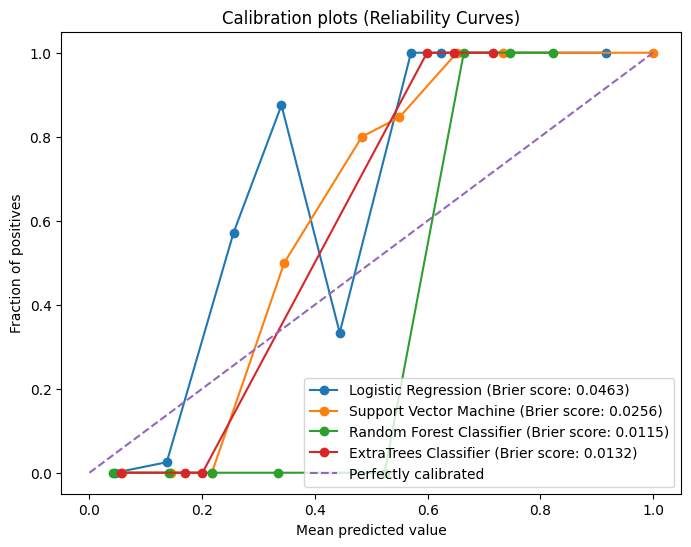

In [10]:
model_dict = {
    "Logistic Regression": probas_dict["grid_search_lr_proba"],
    "Support Vector Machine": probas_dict["grid_search_svm_proba"],
    "Random Forest Classifier": probas_dict["grid_search_rf_proba"],
    "ExtraTrees Classifier": probas_dict["grid_search_et_proba"],
}


# Placeholder for actual Brier scores calculation
brier_scores = {}
for name, proba in model_dict.items():
    brier_score = brier_score_loss(y_test, proba)
    brier_scores[name] = brier_score

plt.figure(figsize=(8, 6))

for name, proba in model_dict.items():
    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(
        y_test, proba, n_bins=10, strategy="uniform"
    )

    # Plot each model's calibration curve with Brier score in the legend
    plt.plot(
        prob_pred,
        prob_true,
        marker="o",
        label=f"{name} (Brier score: {brier_scores[name]:.4f})",
    )

plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title("Calibration plots (Reliability Curves)")
plt.legend()
plt.show()

NameError: name 'non_calibrated_probas_dict' is not defined

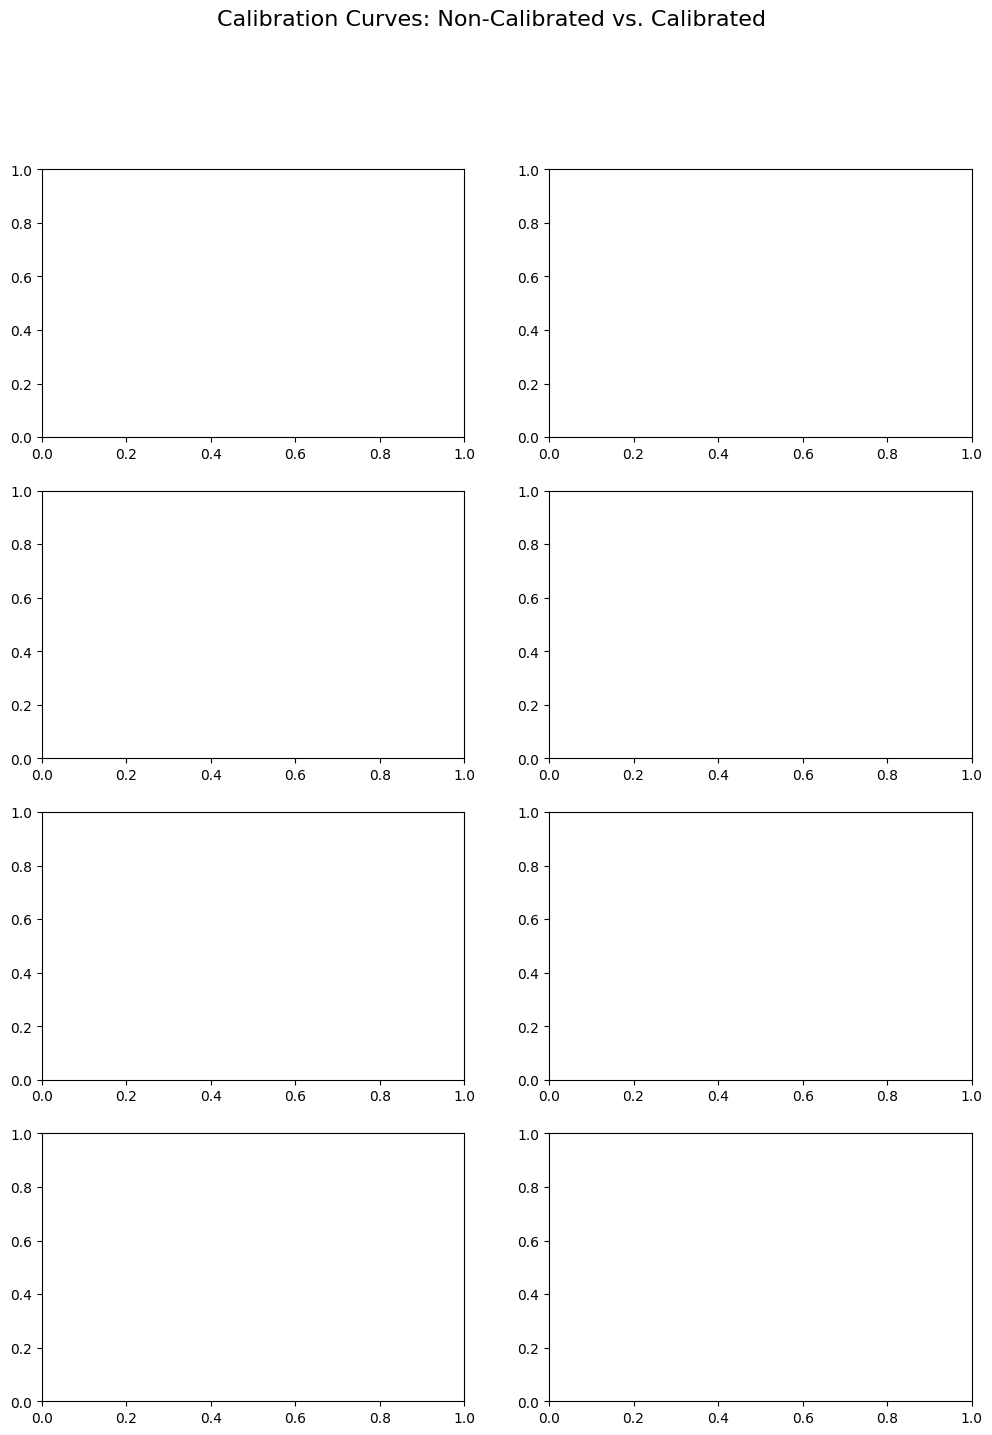

In [11]:
# Number of models
num_models = len(model_list)

# Create figure with subplots - 2 plots per model (non-calibrated and calibrated)
fig, axes = plt.subplots(nrows=num_models, ncols=2, figsize=(12, num_models * 4))
fig.suptitle("Calibration Curves: Non-Calibrated vs. Calibrated", fontsize=16)

for ax, (name, model) in zip(axes, model_list):
    # Non-Calibrated Model
    prob_true_non_calib, prob_pred_non_calib = calibration_curve(
        y_test, non_calibrated_probas_dict[name], n_bins=10, strategy="uniform"
    )
    ax[0].plot(
        prob_pred_non_calib,
        prob_true_non_calib,
        marker="o",
        linestyle="--",
        color="tab:blue",
        label="Non-Calibrated",
    )
    ax[0].plot([0, 1], [0, 1], linestyle=":", color="gray")
    ax[0].set_title(f"{name} Non-Calibrated")
    ax[0].set_xlabel("Mean predicted value")
    ax[0].set_ylabel("Fraction of positives")
    ax[0].legend()

    # Calibrated Model
    prob_true_calib, prob_pred_calib = calibration_curve(
        y_test, probas_dict[f"{name}_proba"], n_bins=10, strategy="uniform"
    )
    ax[1].plot(
        prob_pred_calib,
        prob_true_calib,
        marker="x",
        linestyle="-",
        color="tab:green",
        label="Calibrated",
    )
    ax[1].plot([0, 1], [0, 1], linestyle=":", color="gray")
    ax[1].set_title(f"{name} Calibrated")
    ax[1].set_xlabel("Mean predicted value")
    ax[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
model_df = pd.DataFrame(index=X_test.index)

# Add the scores to the DataFrame
for name, values in probas_dict.items():
    if name.endswith("_score"):
        model_df[name] = values
    elif name.endswith("_proba"):
        model_df[name] = values

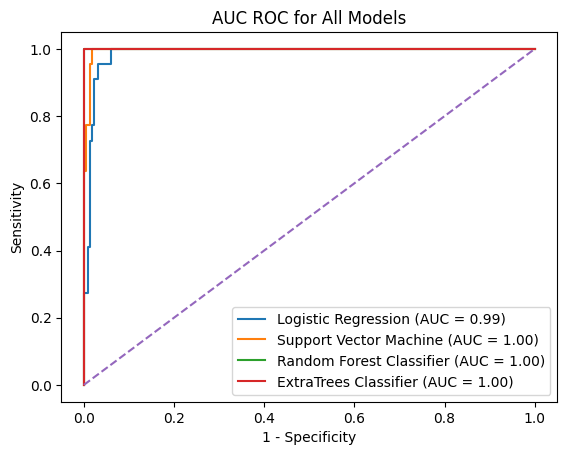

In [13]:
# model_dict = {"Logistic Regression": probas_dict["grid_search_lr_proba"], "Support Vector Machine": probas_dict["grid_search_svm_proba"]}
for name, proba in model_dict.items():
    fpr, tpr, _ = roc_curve(y_test, proba)  # calculate values for TPR, FPR
    auc_models = auc(fpr, tpr)  # calculate the auc for all models
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_models:.2f})")  # plot the ROC AUC

plt.plot([0, 1], [0, 1], "--")
plt.title("AUC ROC for All Models")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend()
plt.show()

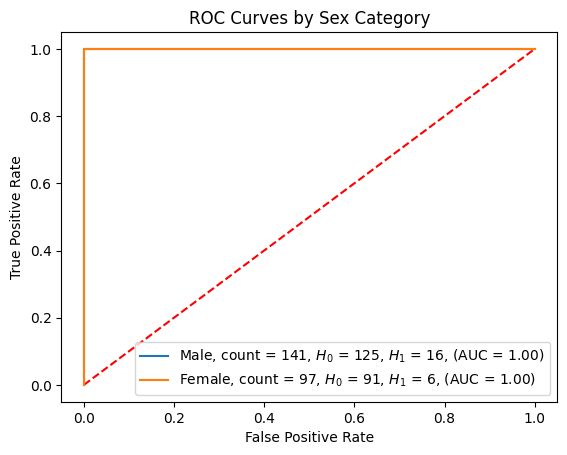

In [14]:
# For instance, using ExtraTrees Classifier predictions from the dictionary
model_predictions = probas_dict["grid_search_rf_proba"]

# Define your custom category labels
category_labels = {
    1: "Male",
    0: "Female",
}  # Extend this dictionary based on your dataset

plot_roc_curves_by_category(
    X_test=X_test,
    y_test=y_test,
    predictions=model_predictions,
    feature="sex",
    category_labels=category_labels,
    outcome="outcome",
    title="ROC Curves by Sex Category",
)

In [ ]:
metrics_dict = {
    "Model": [],
    "AUC ROC": [],
    "PR AUC": [],
    "Precision": [],
    "Recall": [],
    "Specificity": [],
    "Average Precision": [],
    "Brier Score": [],
}

for name, proba in model_dict.items():
    # ROC AUC
    fpr, tpr, thresholds_roc = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)

    # PR AUC
    precision, recall, thresholds_pr = precision_recall_curve(y_test, proba)
    pr_auc = auc(recall, precision)

    # Predicted labels
    predicted_labels = np.where(proba > 0.5, 1, 0)

    # Precision, Recall, and Specificity
    model_precision = precision_score(y_test, predicted_labels)
    model_recall = recall_score(y_test, predicted_labels)
    tn, fp, _, _ = confusion_matrix(y_test, predicted_labels).ravel()
    model_specificity = tn / (tn + fp)
    # Average Precision
    avg_precision = average_precision_score(y_test, proba)

    # Brier Score
    brier_score = brier_score_loss(y_test, proba)

    # Append metrics
    metrics_dict["Model"].append(name)
    metrics_dict["AUC ROC"].append(roc_auc)
    metrics_dict["PR AUC"].append(pr_auc)
    metrics_dict["Precision"].append(model_precision)
    metrics_dict["Recall"].append(model_recall)
    metrics_dict["Specificity"].append(model_specificity)
    metrics_dict["Average Precision"].append(avg_precision)
    metrics_dict["Brier Score"].append(brier_score)

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_dict).set_index("Model").T
metrics_df

In [ ]:
df_audit = df.copy(deep=True)

In [ ]:
df_audit

In [ ]:
df_audit["sex_cat"] = df_audit["sex"].apply(lambda x: "Male" if x == 1 else "Female")

In [ ]:
audit_sex = y_test.join(model_df["grid_search_rf_score"], on="id", how="inner").join(
    df_audit["sex_cat"], on="id", how="inner"
)

In [ ]:
audit_sex = y_test.join(model_df["grid_search_rf_score"], on="id").join(
    df_audit["sex_cat"]
)

In [ ]:
audit_sex

In [ ]:
audit_sex = move_column_before(
    df=audit_sex, target_column="grid_search_rf_score", before_column="sex_cat"
)

In [ ]:
audit_sex.shape

In [ ]:
audit = Audit(df=audit_sex, score_column="grid_search_rf_score", label_column="outcome")
audit.audit()

In [ ]:
audit.confusion_matrix

In [ ]:
audit.metrics.round(2)

In [ ]:
# audit.audit(bias_args={
#     "alpha": 0.05,
#     "check_significance": True,
#     "mask_significance": True
# })

audit.disparity_df.style

In [ ]:
audit.disparities.style

In [ ]:
metrics = ["fpr", "fdr", "pprev"]
disparity_tolerance = 1.25

In [ ]:
audit_sex_groups = Audit(
    df=audit_sex,
    score_column="grid_search_rf_score",
    label_column="outcome",
    reference_groups={"sex_cat": "Male"},
)
audit_sex_groups.audit()

In [ ]:
audit_sex_groups.summary_plot(metrics=metrics, fairness_threshold=disparity_tolerance)

In [ ]:
audit.disparity_plot(
    metrics=metrics, attribute="sex_cat", fairness_threshold=disparity_tolerance
)